# Settings

In [1]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [2]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [3]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, cluster, glmgampoi,
               EnsDb.Hsapiens.v86, 
               logr, parallel, future,
               fpc,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

Warning message:
“package ‘glmgampoi’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘glmgampoi’”
Warning message in pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, :
"Failed to install/load:
glmgampoi"


In [4]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [5]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 4)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)

In [6]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/"
assets.dir = "/nfs/lab/projects/mega_heart/Assets/"

cellranger.links.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/cellranger.symlinks/"

step1.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/"

In [7]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_3.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = c("Muscular", "Vascular", "Neuro", "Stromal", "Immune"))
cell.markers$CellType = factor(cell.markers$CellType,
                        levels = c("CM", "Atrial-CM", "Ventricular-CM",
"SM", "Endothelial", "Endocardial", "Epicardial", "Lymph-Endo", "Pericyte",
"Neuronal", "Fibroblast", "Adipocyte", 
"Macrophage", "T-NK", "NK", "B", "Mast"))

cell.compartment = cell.markers[,-3]

In [8]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".2_SilQC.log", sep="")

In [9]:
log_open(log.file)

[1] "/nfs/lab/projects/mega_heart/log/2024-06-03.2_SilQC.log"

# Load seurat

In [10]:
adata = readRDS(paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.rds", sep = ""))

# Remove doublet clusters

In [11]:
# Remove any obvious sub-populations we want to keep
adata = subset(adata, seurat_clusters %in% c("34", "36"), invert = TRUE)

# Analysis and Harmonization

In [12]:
# RNA analysis
log_print("Starting RNA analysis")
DefaultAssay(adata) <- 'RNA'
log_print("  - SCTransform")
adata <- SCTransform(adata, verbose=FALSE)
gc(reset = TRUE)
log_print("  - RunPCA")
adata <- RunPCA(adata)
log_print("  - RunHarmony")
adata <- RunHarmony(adata, group.by.vars= c('library'), assay.use='SCT', reduction.save='harmony.rna')
log_print("  - RunUMAP")
adata <- RunUMAP(adata, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')

[1] "Starting RNA analysis"
[1] "  - SCTransform"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13655644,729.3,22716572,1213.2,13655644,729.3
Vcells,9828637507,74986.6,64626673539,493062.4,9828637507,74986.6


[1] "  - RunPCA"


PC_ 1 
Positive:  RYR2, TTN, FGF12, FHL2, CTNNA3, DMD, SLC8A1, SORBS2, MLIP, CACNA1C 
	   RBM20, SGCD, PDE3A, LINC02208, MYOM1, TECRL, PALLD, NEBL, AC092353.2, PDLIM5 
	   ANKRD1, CACNB2, CDH2, TTN-AS1, ERBB4, LDB3, CHRM2, FHOD3, TRDN, TRDN-AS1 
Negative:  F13A1, MRC1, DCN, RBPJ, FMN1, CD163, GSN, MGP, CDH19, CFD 
	   MAN1A1, LDB2, NEGR1, POSTN, CD163L1, ST6GALNAC3, MERTK, C7, RBM47, RAB31 
	   PLXDC2, CFH, VCAN, PLA2G2A, SLC9A9, PKHD1L1, SIPA1L1, MECOM, CPM, MS4A6A 
PC_ 2 
Positive:  F13A1, MRC1, RBPJ, FMN1, CD163, CD163L1, MERTK, MAN1A1, RBM47, PDGFC 
	   MS4A6A, RAB31, CPM, TBXAS1, MS4A4A, FGF13, SMAP2, IQGAP2, SLCO2B1, LYVE1 
	   SIPA1L1, MS4A4E, KCNMA1, PTPRC, MSR1, TLR2, SAMSN1, AL162414.1, AOAH, MS4A7 
Negative:  DCN, CDH19, GSN, MGP, NEGR1, CFD, C7, CFH, KAZN, PLA2G2A 
	   SCN7A, LAMA2, APOD, LUM, IGFBP7, POSTN, ACSM3, FN1, BICC1, SPARCL1 
	   FBN1, FBLN1, CCN2, EBF1, COL3A1, ABCA10, COL1A2, KCNT2, COL6A3, NOX4 
PC_ 3 
Positive:  DCN, CDH19, NEGR1, CFD, GSN, F13A1, MGP, LAMA2, 

[1] "  - RunHarmony"


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



[1] "  - RunUMAP"


00:17:41 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

00:17:41 Read 345616 rows and found 50 numeric columns

00:17:41 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

00:17:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:18:59 Writing NN index file to temp file /nfs/lab/Luca/TMP/RtmprkWvyn/file182e5e360e6caf

00:19:03 Searching Annoy index using 4 threads, search_k = 3000

00:19:56 Annoy recall = 96.16%

00:19:58 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 30

00:20:20 Initializing from nor

In [13]:
# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)
log_print("  - RunHarmony")
hm_atac <- HarmonyMatrix(Embeddings(adata, reduction='lsi'), 
                         vars_use = c('library'), meta_data = adata@meta.data, 
                         do_pca=FALSE)
adata[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
log_print("  - RunUMAP")
adata <- RunUMAP(adata, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')

[1] "Starting ATAC analysis"
[1] "  - RunTFIDF"


Performing TF-IDF normalization



[1] "  - RunSVD"


Running SVD

Scaling cell embeddings



[1] "  - RunHarmony"


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



[1] "  - RunUMAP"


01:17:14 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

01:17:14 Read 345616 rows and found 49 numeric columns

01:17:14 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

01:17:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:18:03 Writing NN index file to temp file /nfs/lab/Luca/TMP/RtmprkWvyn/file182e5e7a7f3559

01:18:07 Searching Annoy index using 4 threads, search_k = 3000

01:19:11 Annoy recall = 100%

01:19:14 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 30

01:19:34 Initializing from norma

In [14]:
# Combining Modalities
log_print("Combining Modalities")
log_print("  - FindMultiModalNeighbors")
adata <- FindMultiModalNeighbors(adata, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
log_print("  - RunUMAP")
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
log_print("  - FindClusters")
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.6, verbose=FALSE, method = 'igraph')

adata$log_nCount_ATAC=log(adata$nCount_ATAC)
adata$log_nCount_SCT=log(adata$nCount_SCT)
adata$log_nFeature_ATAC=log(adata$nFeature_ATAC)
adata$log_nFeature_SCT=log(adata$nFeature_SCT)

[1] "Combining Modalities"
[1] "  - FindMultiModalNeighbors"


Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



[1] "  - RunUMAP"


01:43:45 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

01:43:50 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 20

01:43:50 5 smooth knn distance failures

01:44:03 Initializing from normalized Laplacian + noise (using RSpectra)

01:46:25 Commencing optimization for 200 epochs, with 11469398 positive edges

01:50:17 Optimization finished



[1] "  - FindClusters"


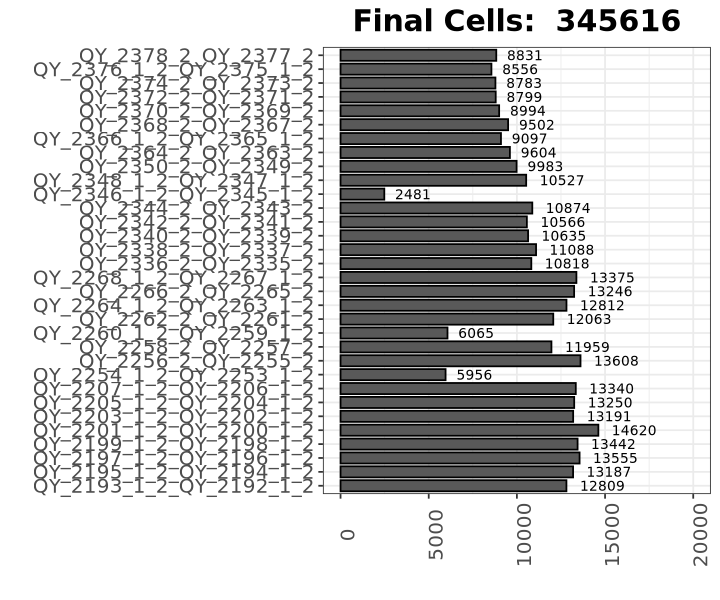

In [15]:
cell.sample = as.data.frame(table(adata$library))
colnames(cell.sample)[1] = "sample.ID"

options(repr.plot.width=6, repr.plot.height=5)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(cell.sample, aes(x= sample.ID, y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 20000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()
gg1

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



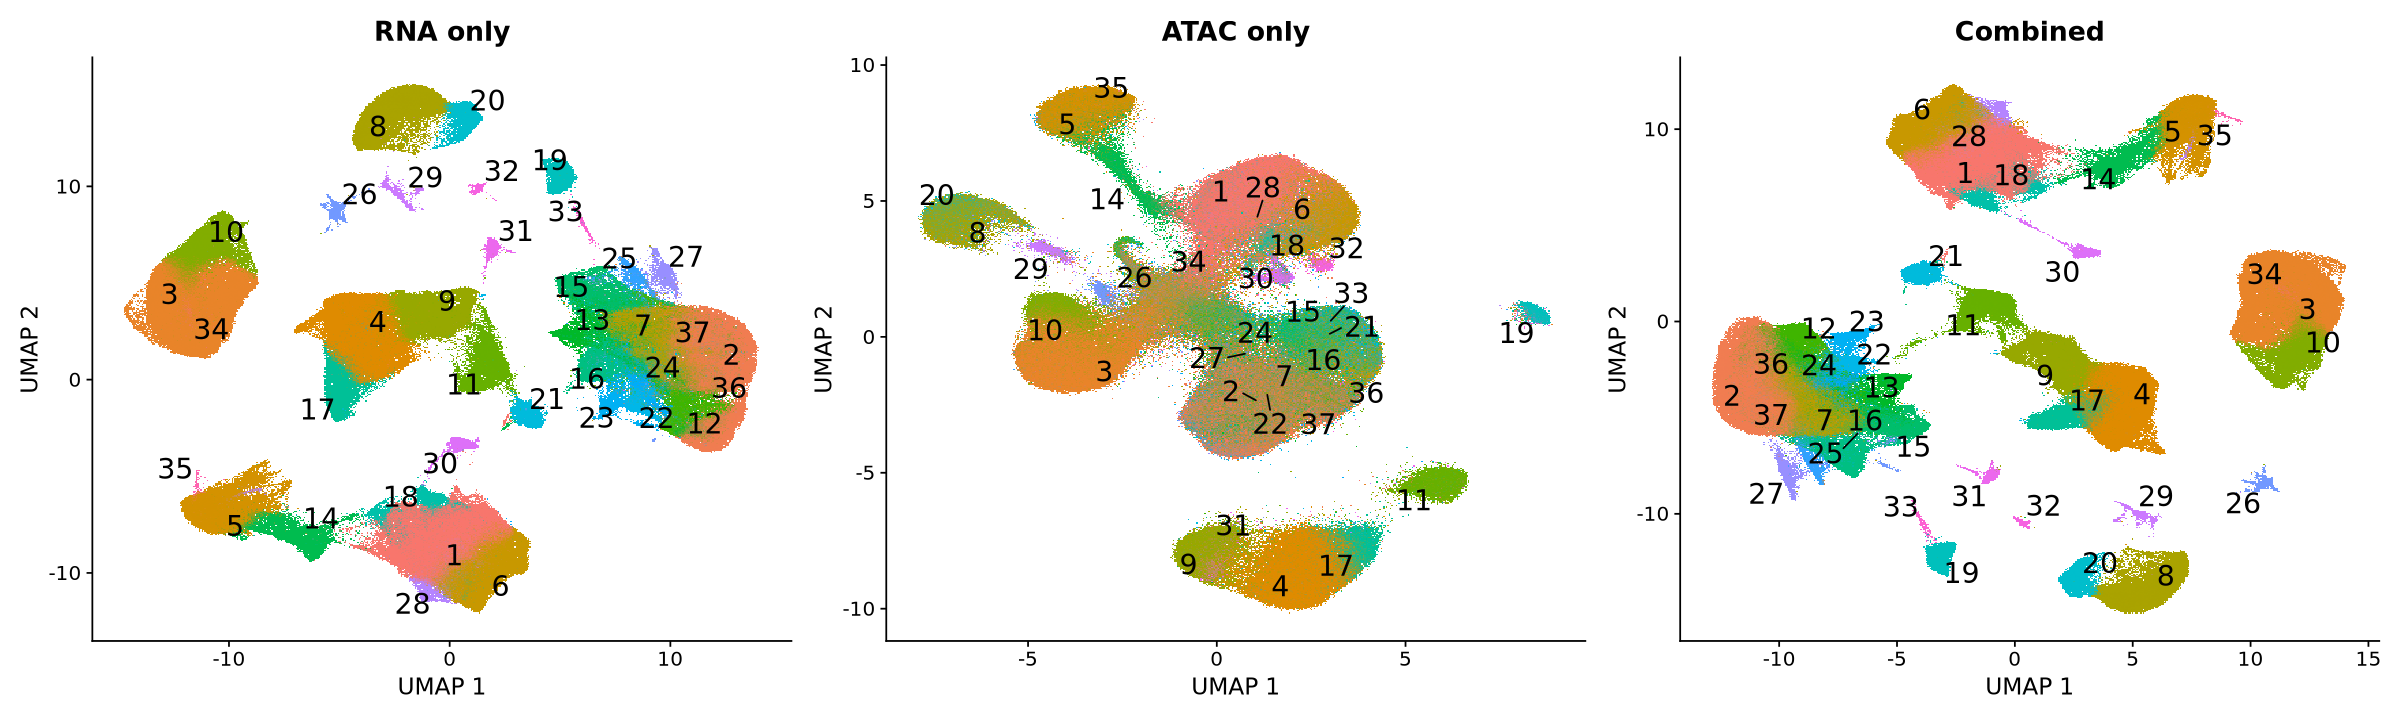

In [16]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

In [17]:
cell.cluster = as.data.frame(table(adata$chamber, adata$seurat_clusters))
colnames(cell.cluster)[1] = "chamber"
colnames(cell.cluster)[2] = "seurat_clusters"
cell.cluster = dplyr::filter(cell.cluster, Freq != 0)

In [18]:
table(adata$seurat_clusters)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
41522 40057 37479 30853 22041 20288 17617 15087 15123 12259  9534  8801  7800 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
 7533  7311  6496  6248  4419  4148  3687  3111  3098  2712  2683  2288  2171 
   27    28    29    30    31    32    33    34    35    36    37 
 2100  2074  1722  1704  1639  1199   424   209   175     2     2 

In [19]:
width = 0.8
gg1 = ggplot(cell.cluster, aes(x= seurat_clusters, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

gg2 = ggplot(cell.cluster, aes(x= seurat_clusters, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                  axis.text.y = element_blank(),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

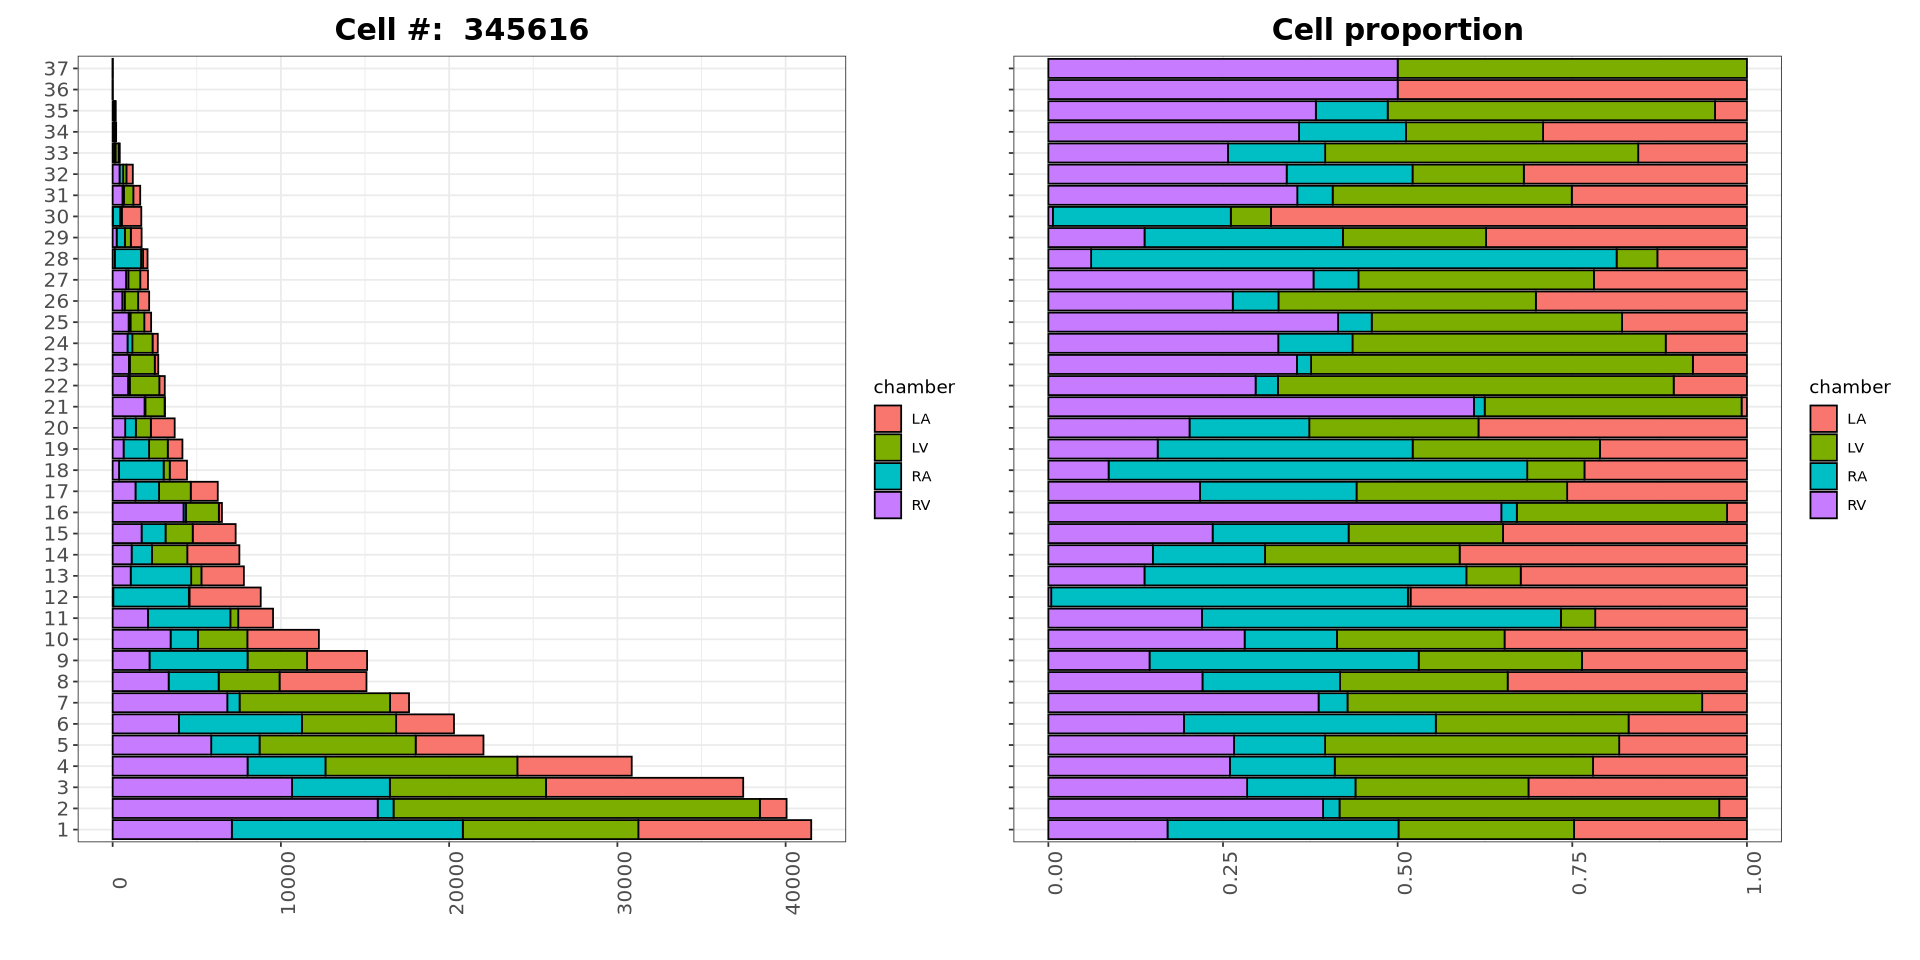

In [20]:
options(repr.plot.width=16, repr.plot.height=8)
gg1 + gg2 & theme(plot.title=element_text(hjust=0.5))

# Celltype assignment

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



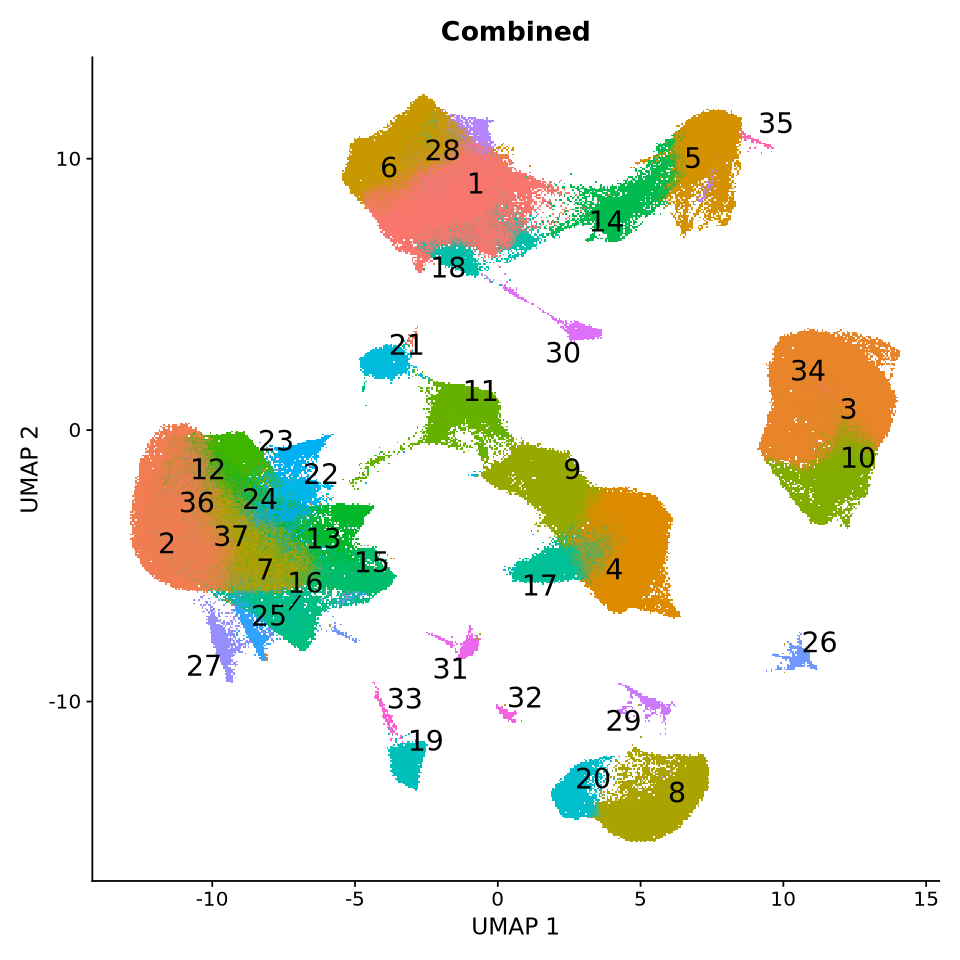

In [22]:
options(repr.plot.width=8, repr.plot.height=8)
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

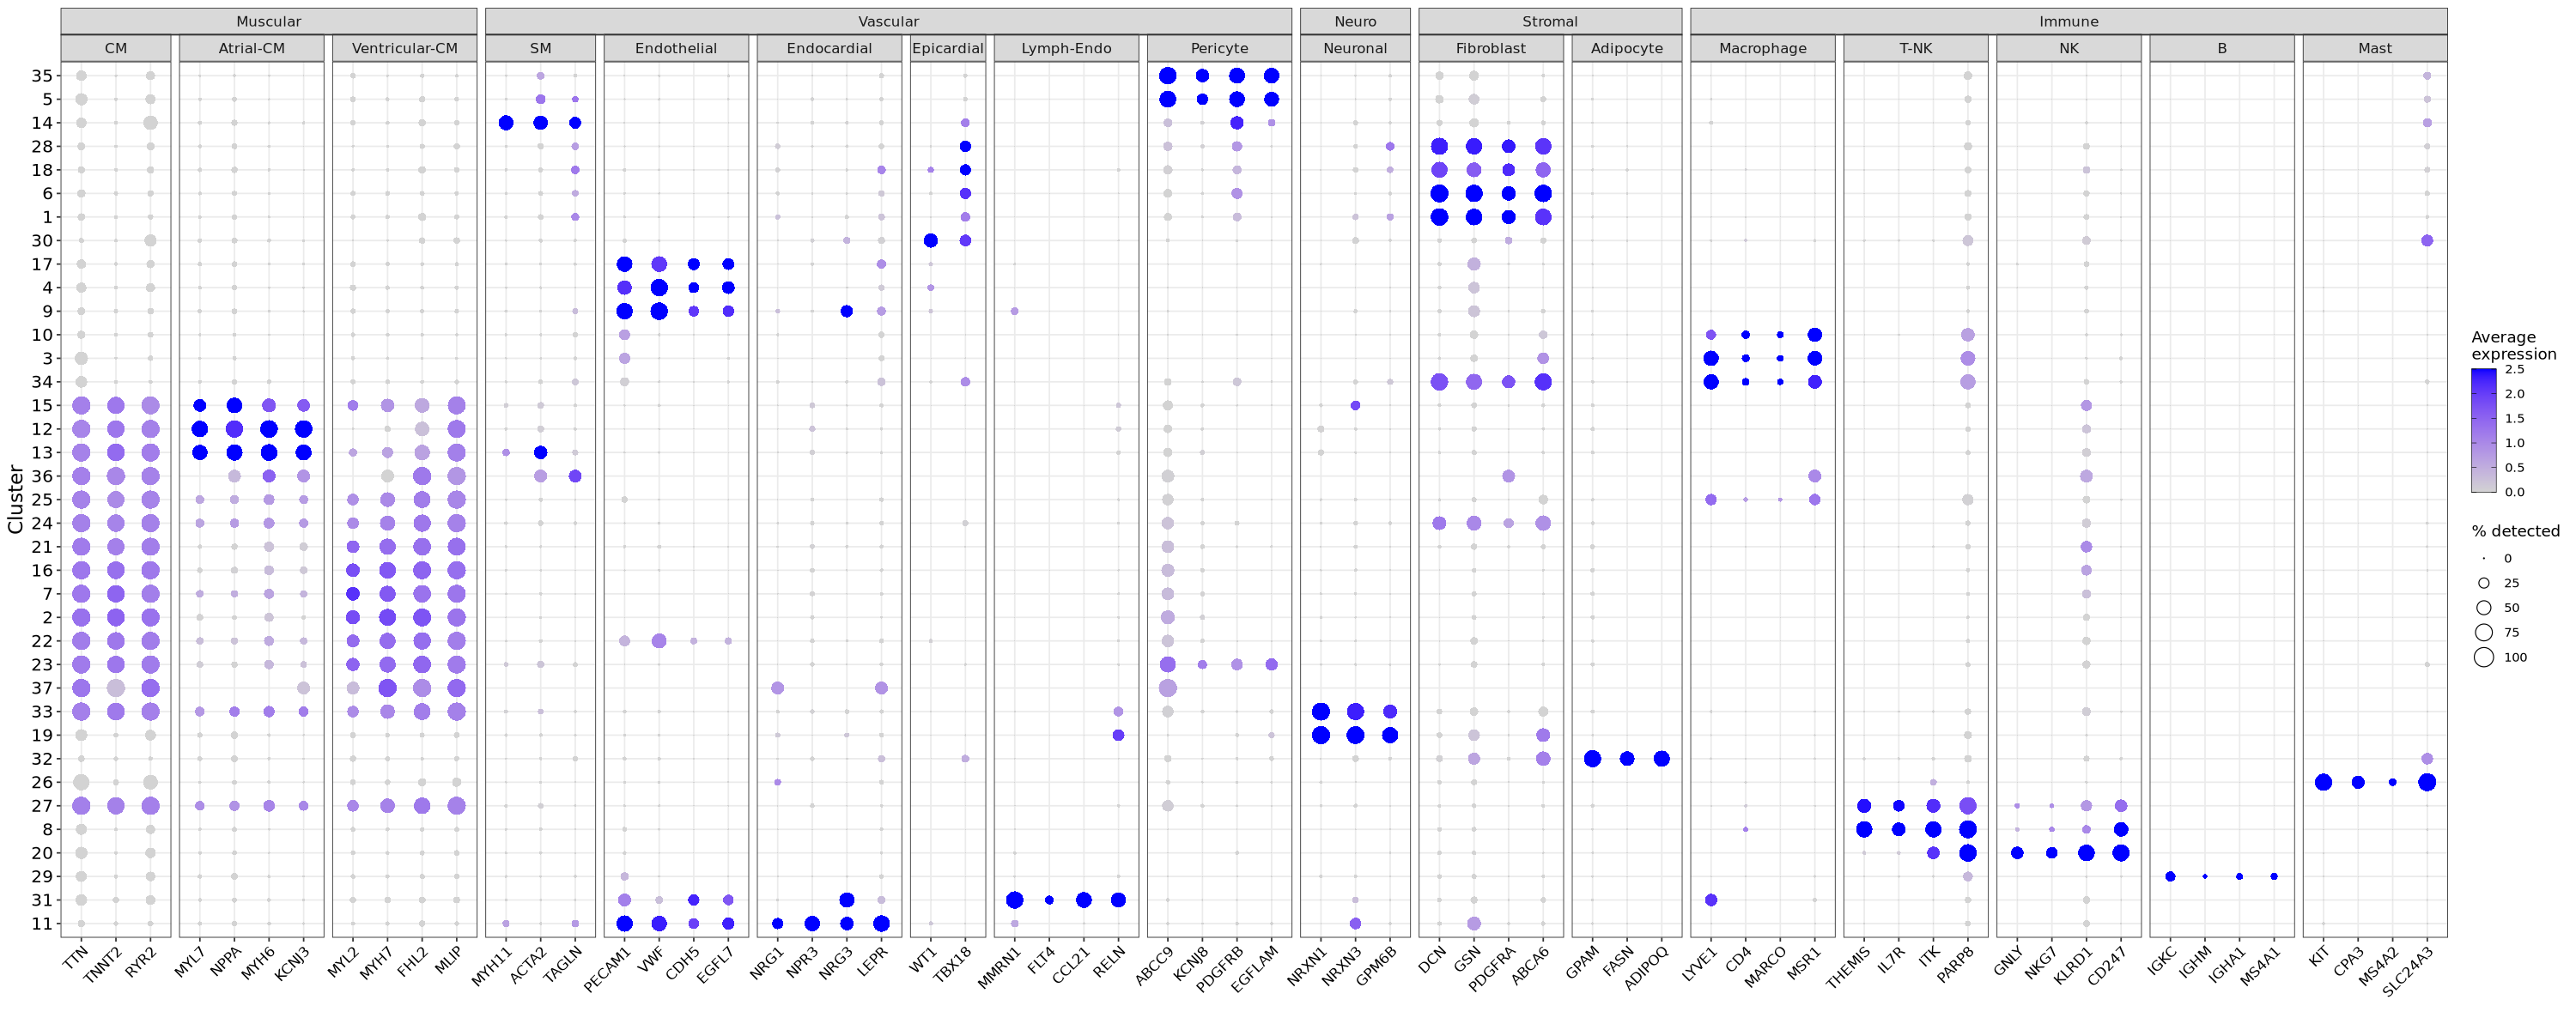

In [23]:
g = DotPlot(adata, assay='SCT', features=cell.markers$marker, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=25, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [24]:
levels(cell.markers$CellType)

[1] "CM"             "Atrial-CM"      "Ventricular-CM" "SM"            
 [5] "Endothelial"    "Endocardial"    "Epicardial"     "Lymph-Endo"    
 [9] "Pericyte"       "Neuronal"       "Fibroblast"     "Adipocyte"     
[13] "Macrophage"     "T-NK"           "NK"             "B"             
[17] "Mast"

In [27]:
# list cluster numbers as they appear in the dotplot
# list cluster numbers as they appear in the dotplot
clusters = rev(levels(g$data$id))
clusters

# visually determine celltypes
celltypes = c('Pericyte', 'Pericyte', 
              'SM', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast',
              'Epicardial', 'Endothelial', 'Endothelial', 'Endothelial',
              'Macrophage', 'Macrophage', 'Macrophage',
              'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM', 'CM',
              'Neuronal',
              'Adipocyte', 'Mast', 'CM', 
              "T", "NK",
              "B", 
              'Lymph-Endo', 'Endocardial'
             )

length(clusters)
length(celltypes)

clusters.celltypes = data.frame(seurat_clusters = clusters,
                               celltypes = celltypes)

[1] "35" "5"  "14" "28" "18" "6"  "1"  "30" "17" "4"  "9"  "10" "3"  "34" "15"
[16] "12" "13" "36" "25" "24" "21" "16" "7"  "2"  "22" "23" "37" "33" "19" "32"
[31] "26" "27" "8"  "20" "29" "31" "11"

[1] 37

[1] 37

In [28]:
# Assign celltypes
adata <- SetIdent(adata, value = adata$seurat_clusters)
levels(adata)
adata$celltypes <- clusters.celltypes$celltypes[match(adata$seurat_clusters, clusters.celltypes$seurat_clusters)]
adata <- SetIdent(adata, value = adata$celltypes)
levels(adata)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37"

[1] "Fibroblast"  "Endothelial" "CM"          "Macrophage"  "Pericyte"   
 [6] "Mast"        "Endocardial" "T"           "SM"          "B"          
[11] "Neuronal"    "NK"          "Lymph-Endo"  "Epicardial"  "Adipocyte"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



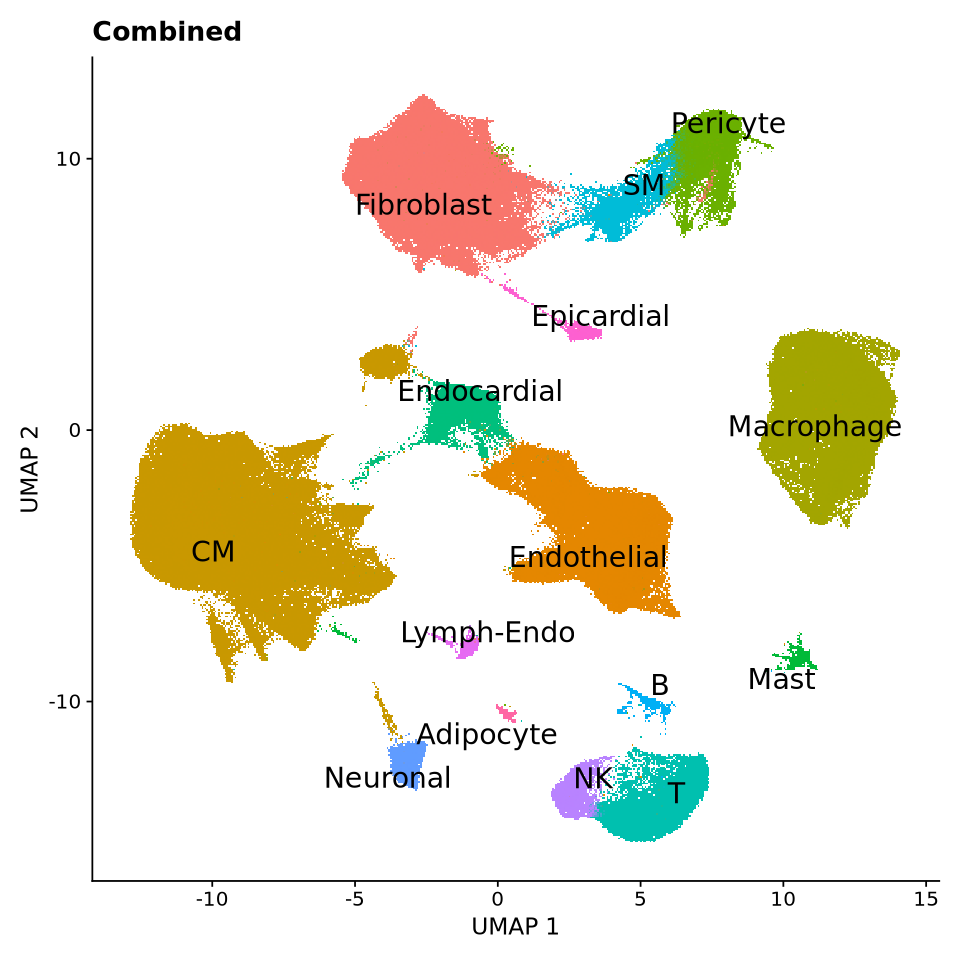

In [29]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

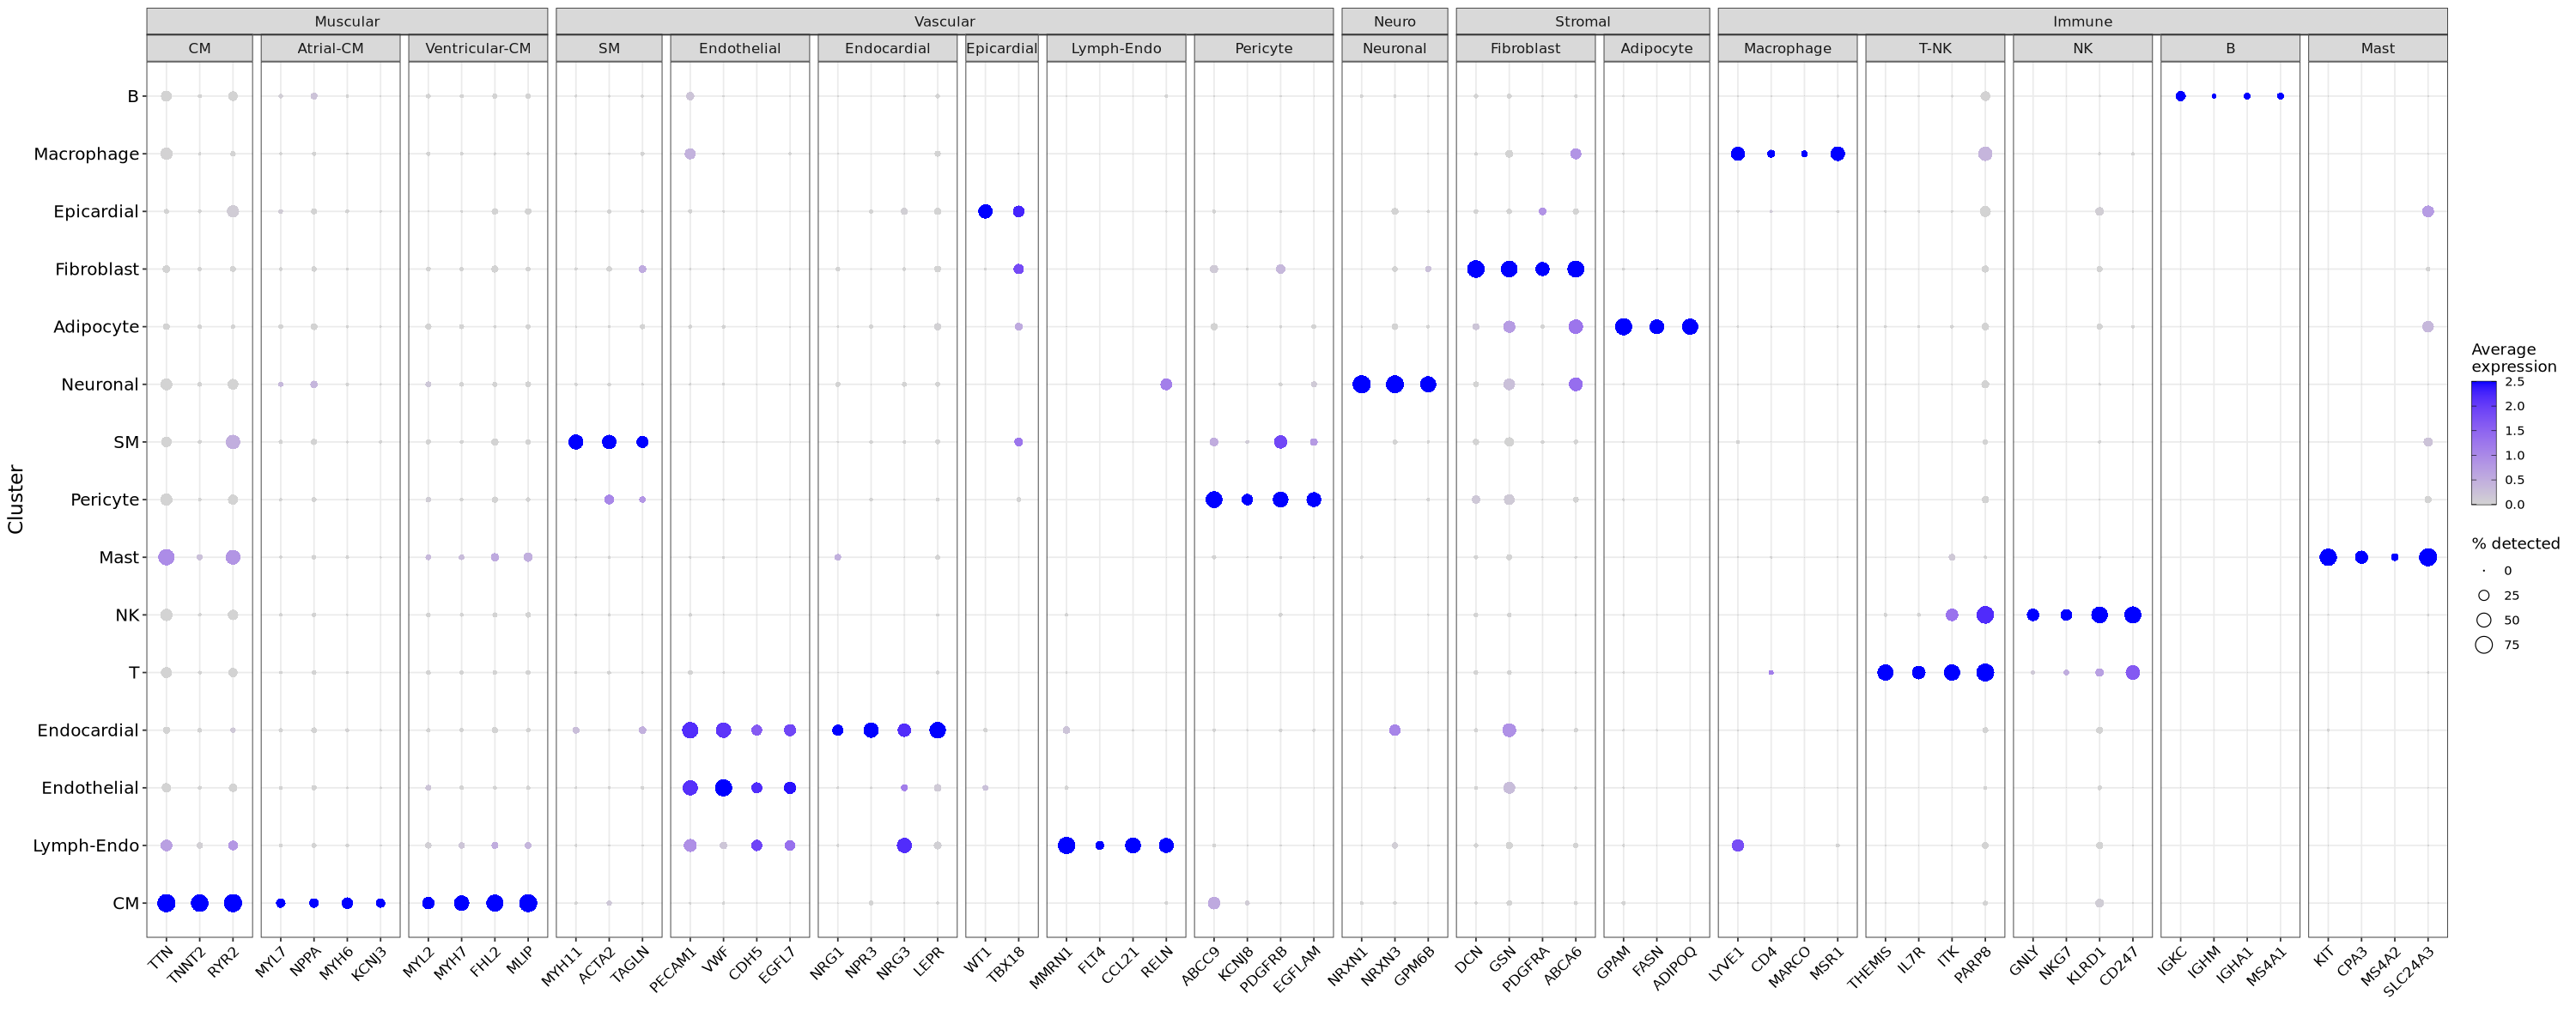

In [30]:
g = DotPlot(adata, assay='SCT', features=cell.markers$marker, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=25, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

# Celltype QC

In [31]:
cell.sample = as.data.frame(table(adata$celltypes, adata$donor, adata$chamber, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "donor"
colnames(cell.sample)[3] = "chamber"
colnames(cell.sample)[4] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$chamber = factor(cell.sample$chamber, levels = c("LA", "RA", "LV", "RV"))

In [32]:
width = 0.8
gg1 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip() +
            facet_wrap(~ chamber, scales = "fixed", ncol = 1)

gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip() +
            facet_wrap(~ chamber, scales = "fixed", ncol = 1)

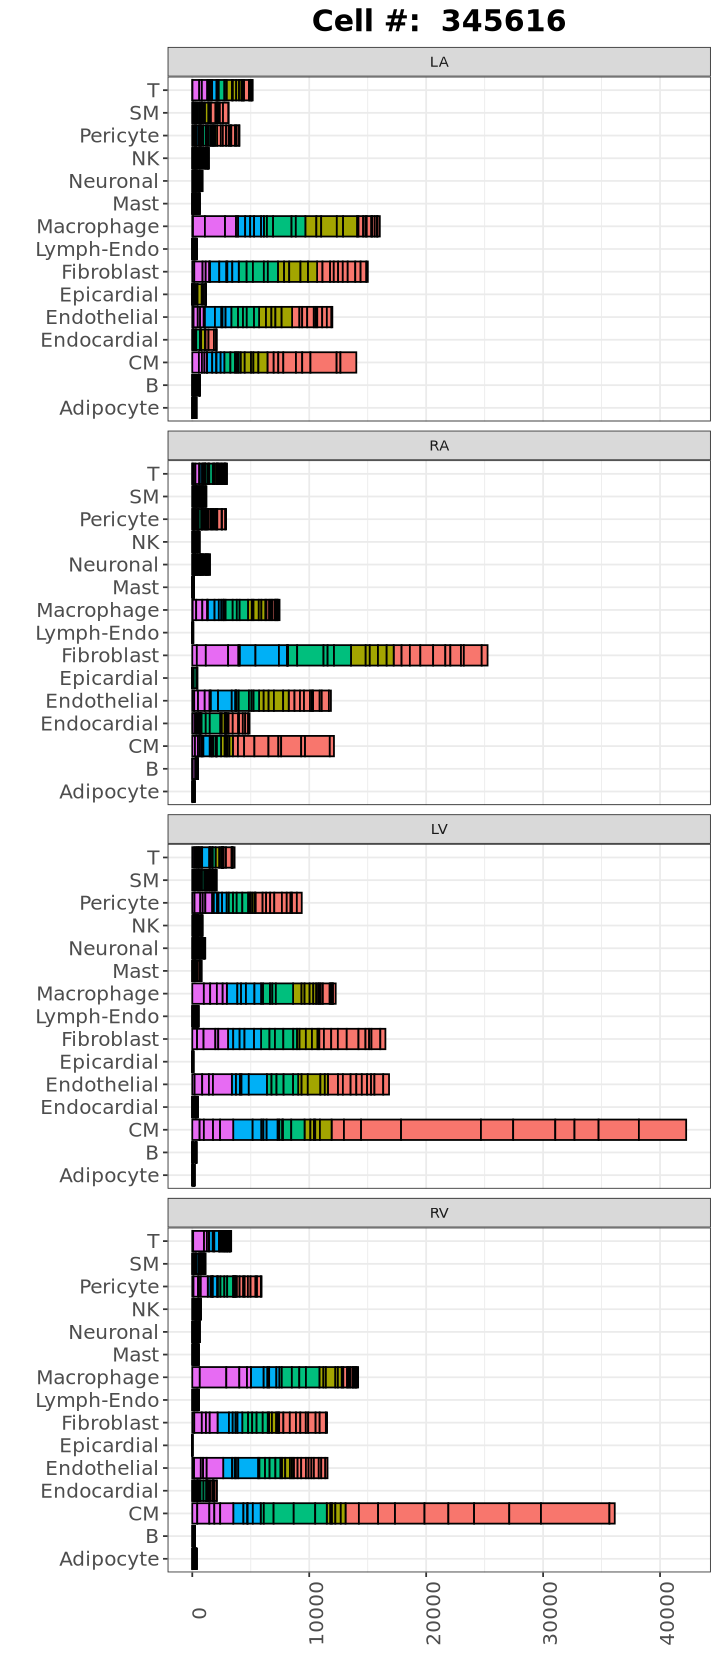

In [33]:
options(repr.plot.width=6, repr.plot.height=14)
gg1 & NoLegend()

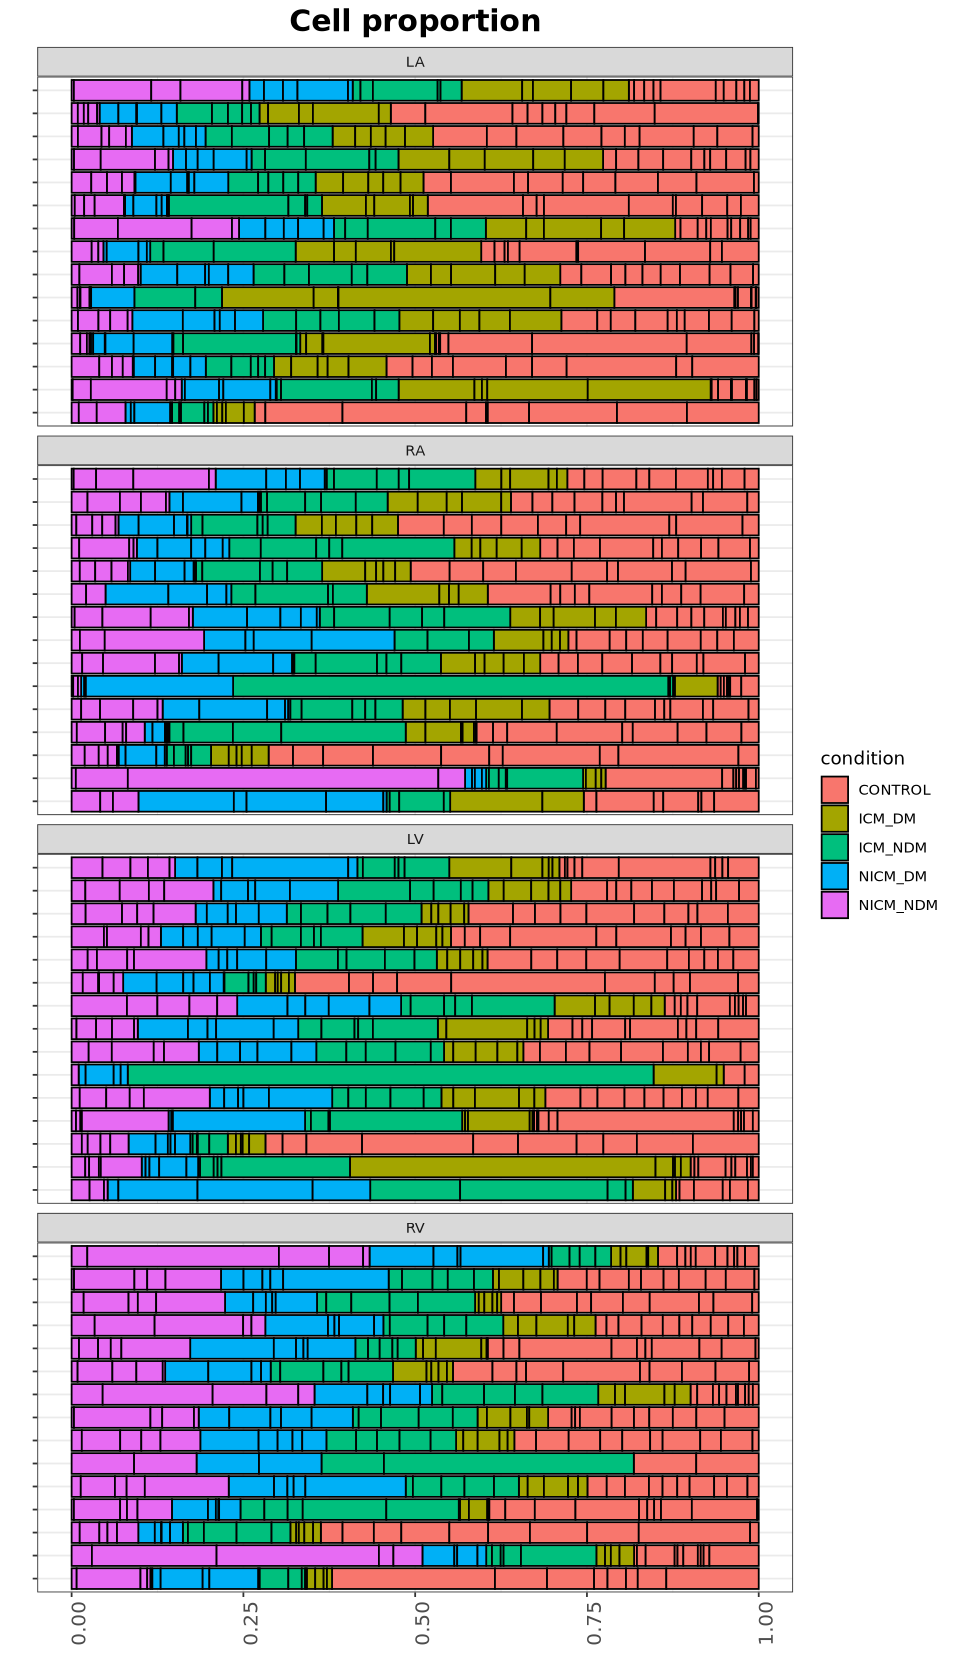

In [34]:
options(repr.plot.width=8, repr.plot.height=14)
gg2

In [35]:
cell.cluster = as.data.frame(table(adata$celltypes))
colnames(cell.cluster)[1] = "celltype"
width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(cell.cluster, aes(x= reorder(celltype, +Freq), y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 150000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()

# numbers per condition
cell.sample = as.data.frame(table(adata$celltypes, adata$chamber))
colnames(cell.sample)[1] = "celltype"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

gg2 = ggplot(cell.sample, aes(x= reorder(celltype, +Freq), y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Breakdown by chamber")) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                  plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip() & NoLegend()

gg3 = ggplot(cell.sample, aes(x= reorder(celltype, +Freq), y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Proportion by chamber")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),,
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

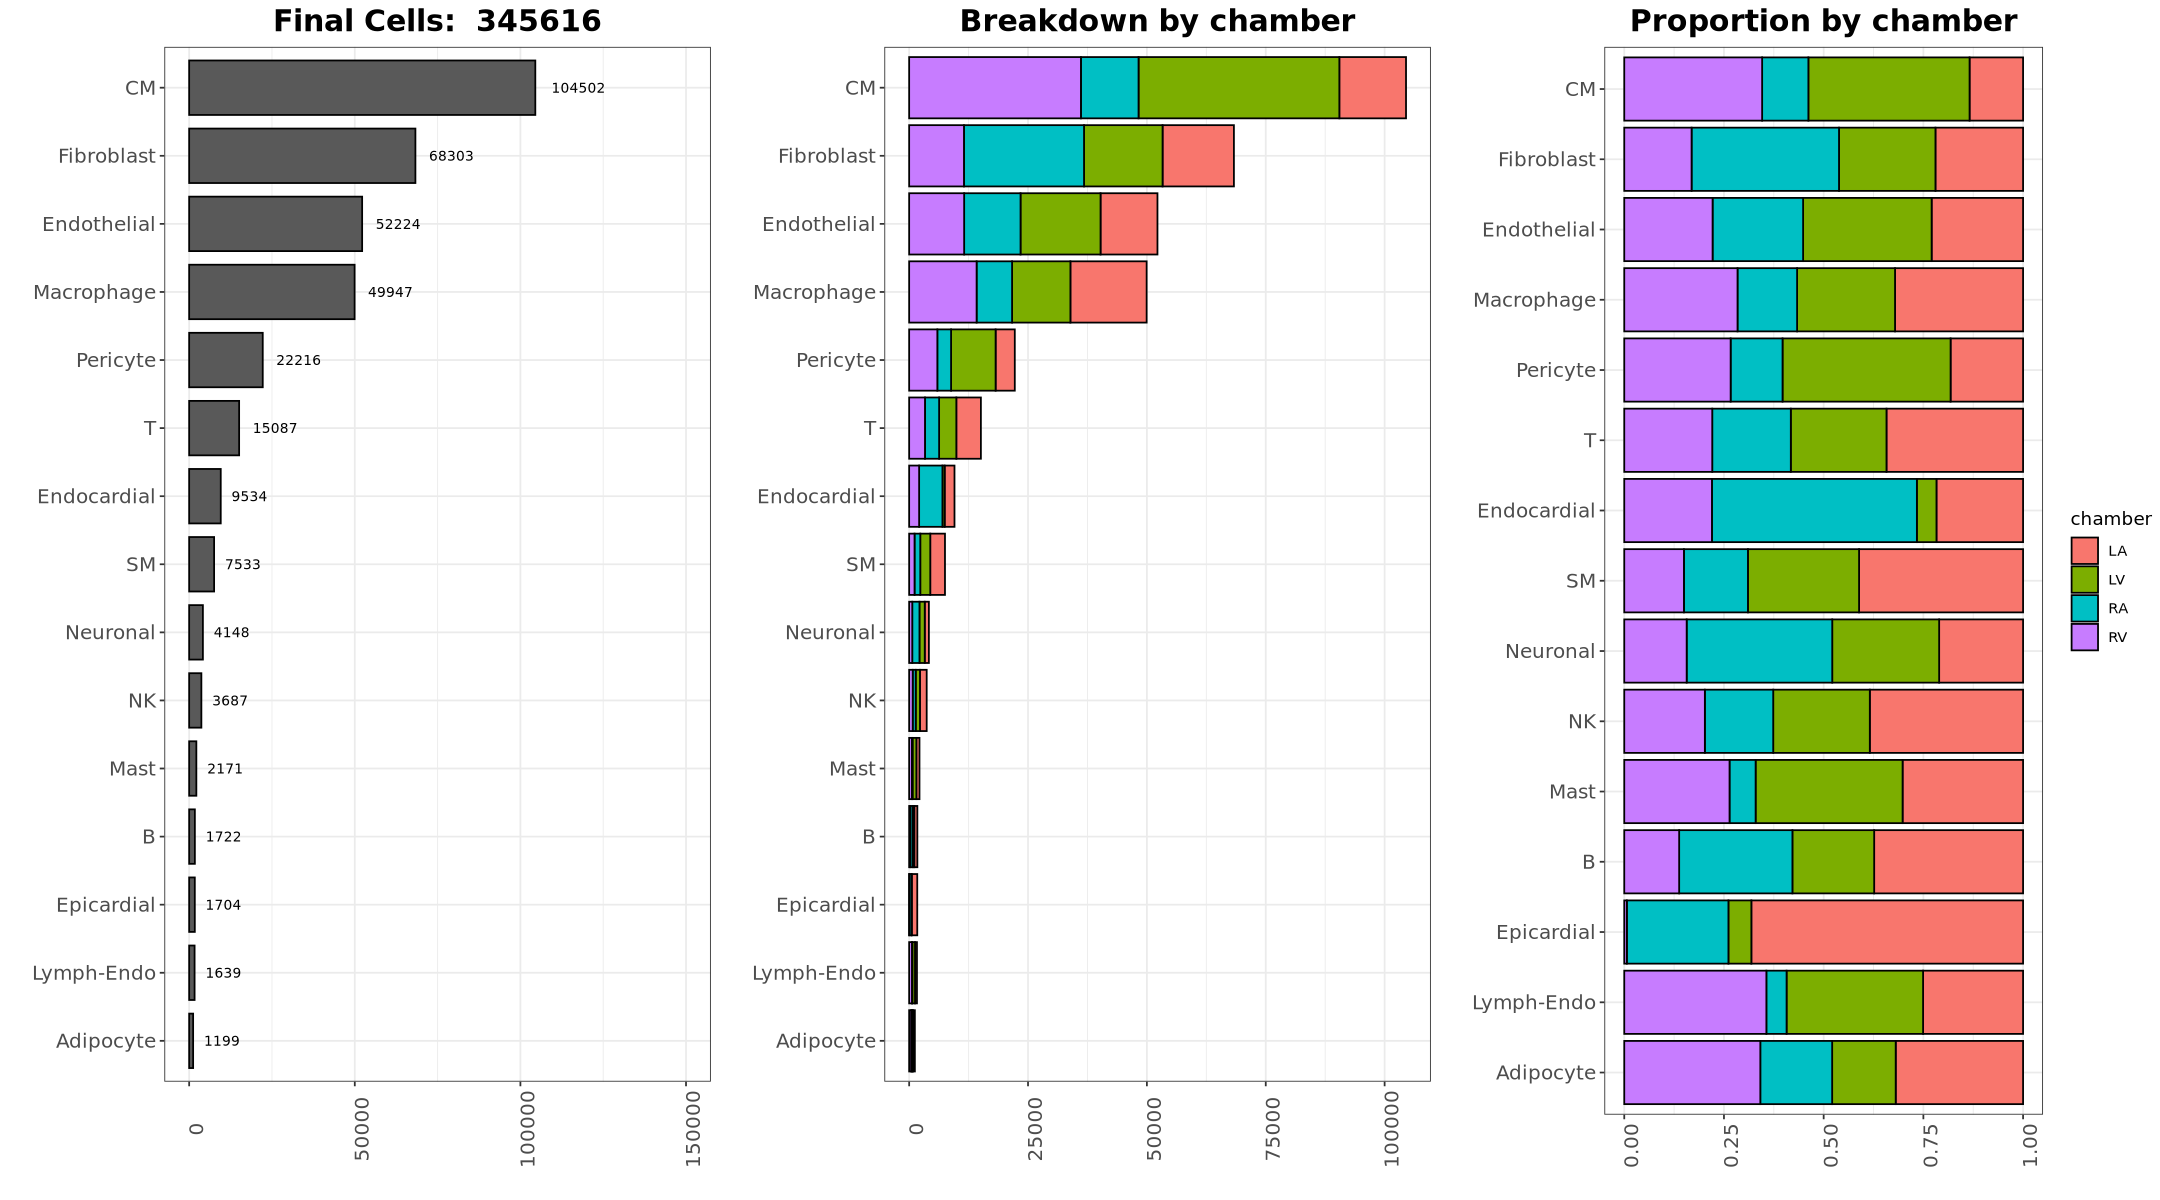

In [36]:
options(repr.plot.height = 10, repr.plot.width = 18)
ggarrange(gg1, gg2, gg3, ncol = 3, nrow = 1)

In [37]:
# Create a combined metadata column to summarize clusters and celltypes
adata$cluster_celltype = paste0(adata$celltypes, "--", adata$seurat_clusters)

In [38]:
# RNA plots
    p1 <- VlnPlot(adata, features='nFeature_RNA', group.by = 'cluster_celltype', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_RNA, na.rm = TRUE), linetype='dashed', lw=2) + 
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p2 <- VlnPlot(adata, features='percent.mt', group.by = 'cluster_celltype', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$percent.mt, na.rm = TRUE), linetype='dashed')+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

# ATAC plots
    p3 <- VlnPlot(adata, features='atac_fragments', group.by = 'cluster_celltype', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$atac_fragments, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p4 <- VlnPlot(adata, features='TSS.enrichment', group.by = 'cluster_celltype', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$TSS.enrichment, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

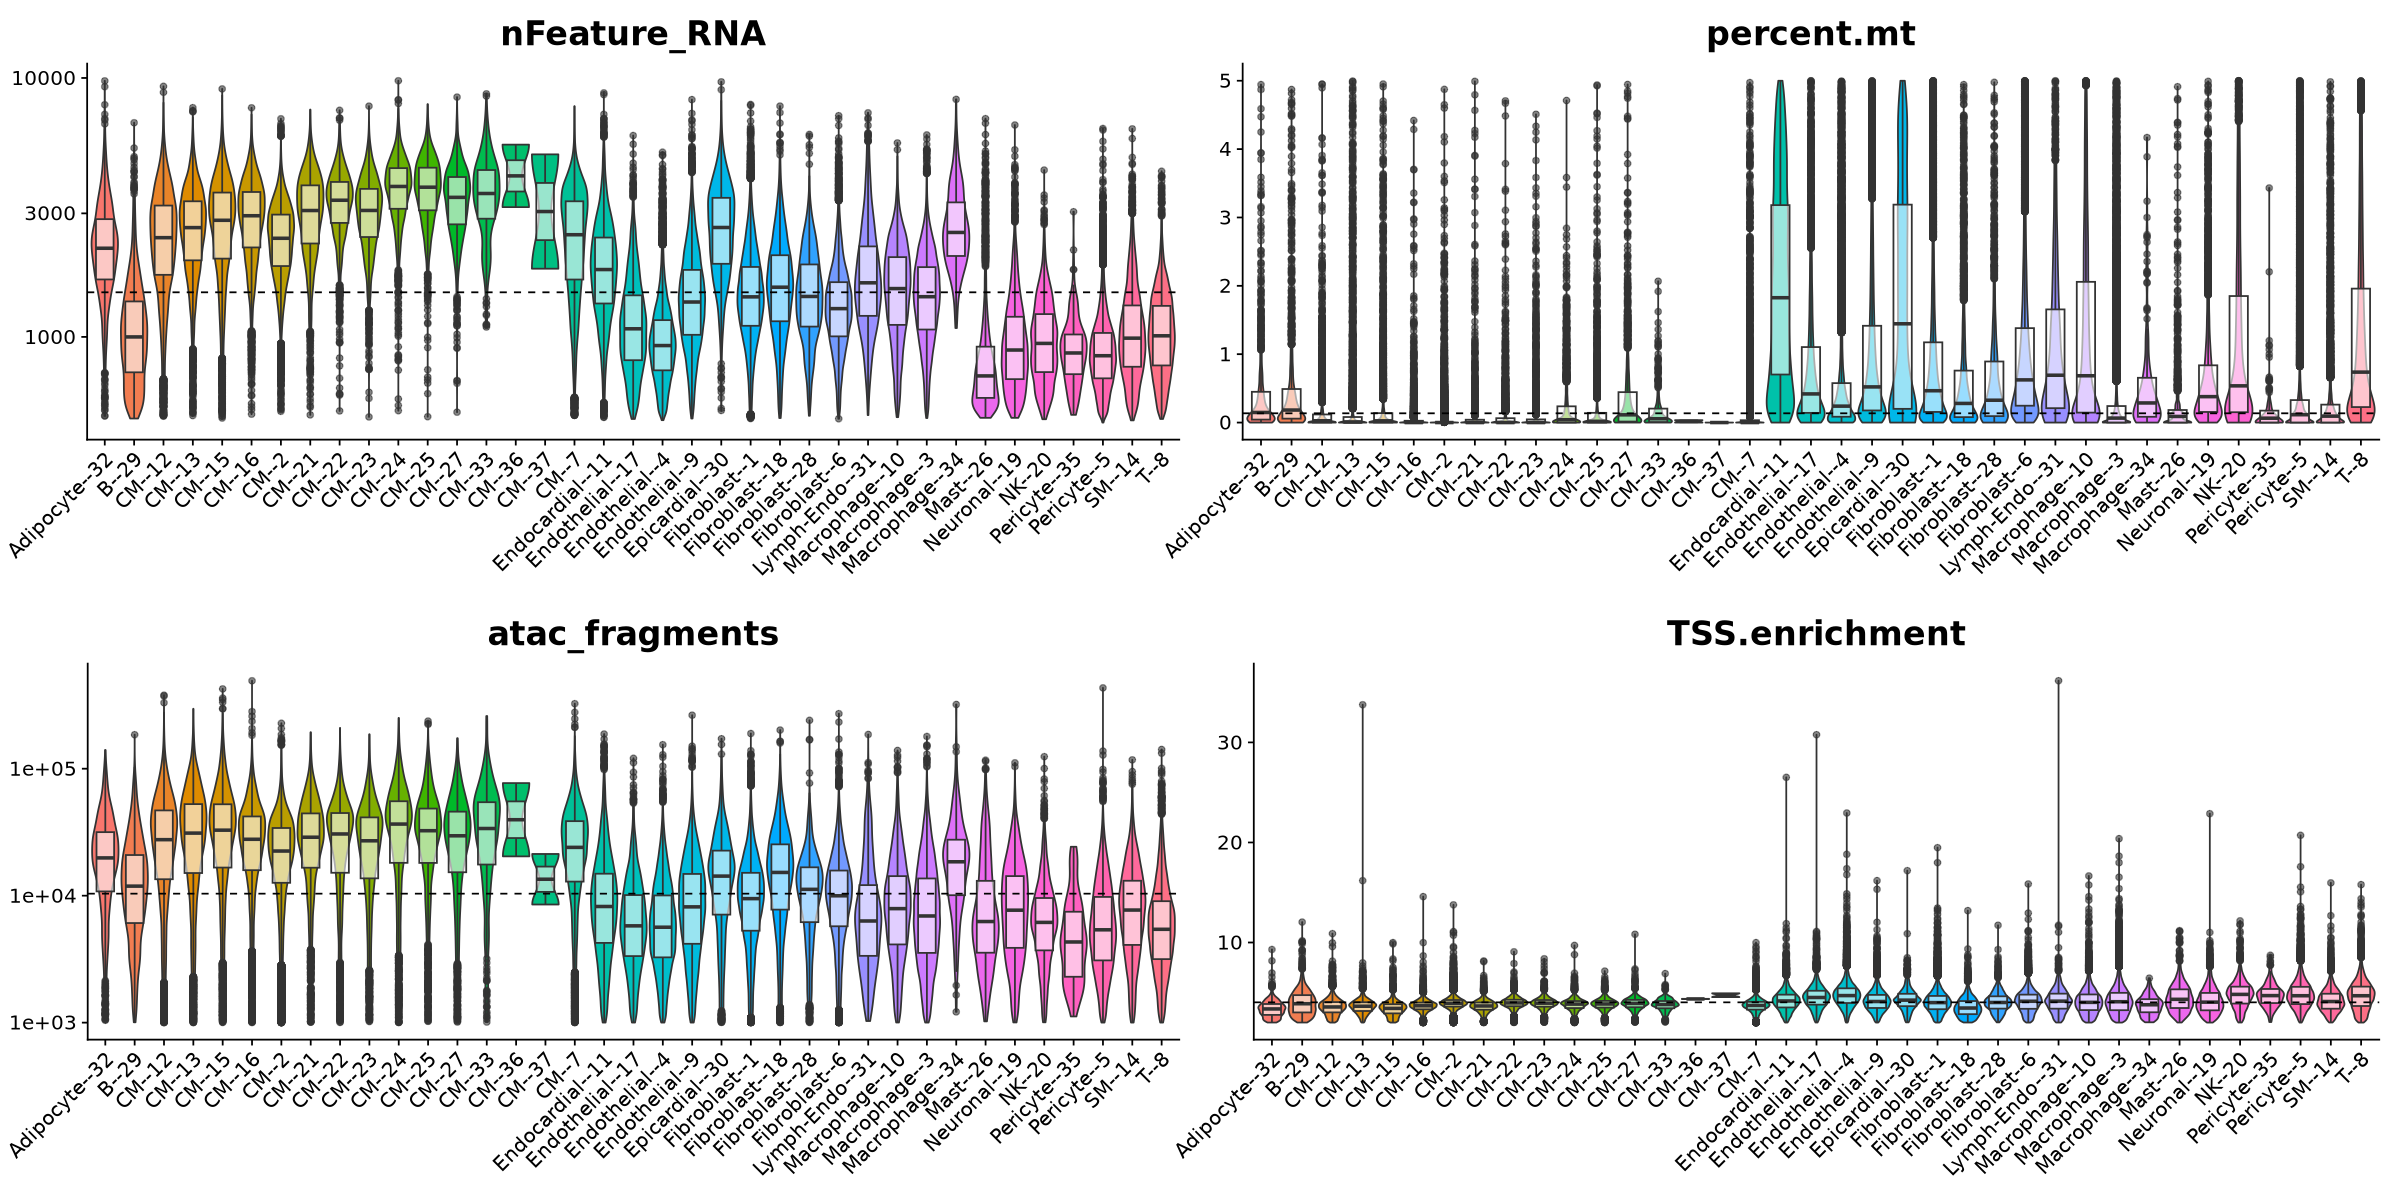

In [39]:
options(repr.plot.height = 10, repr.plot.width = 20)
ggarrange(p1, p2, p3, p4, 
          ncol = 2, nrow = 2,
          common.legend = TRUE,legend="none")

In [40]:
cell.sample = as.data.frame(table(adata$cluster_celltype, adata$condition))
colnames(cell.sample)[1] = "cluster_celltype"
colnames(cell.sample)[2] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

In [41]:
width = 0.8
gg1 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

gg2 = ggplot(cell.sample, aes(x= cluster_celltype, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip()

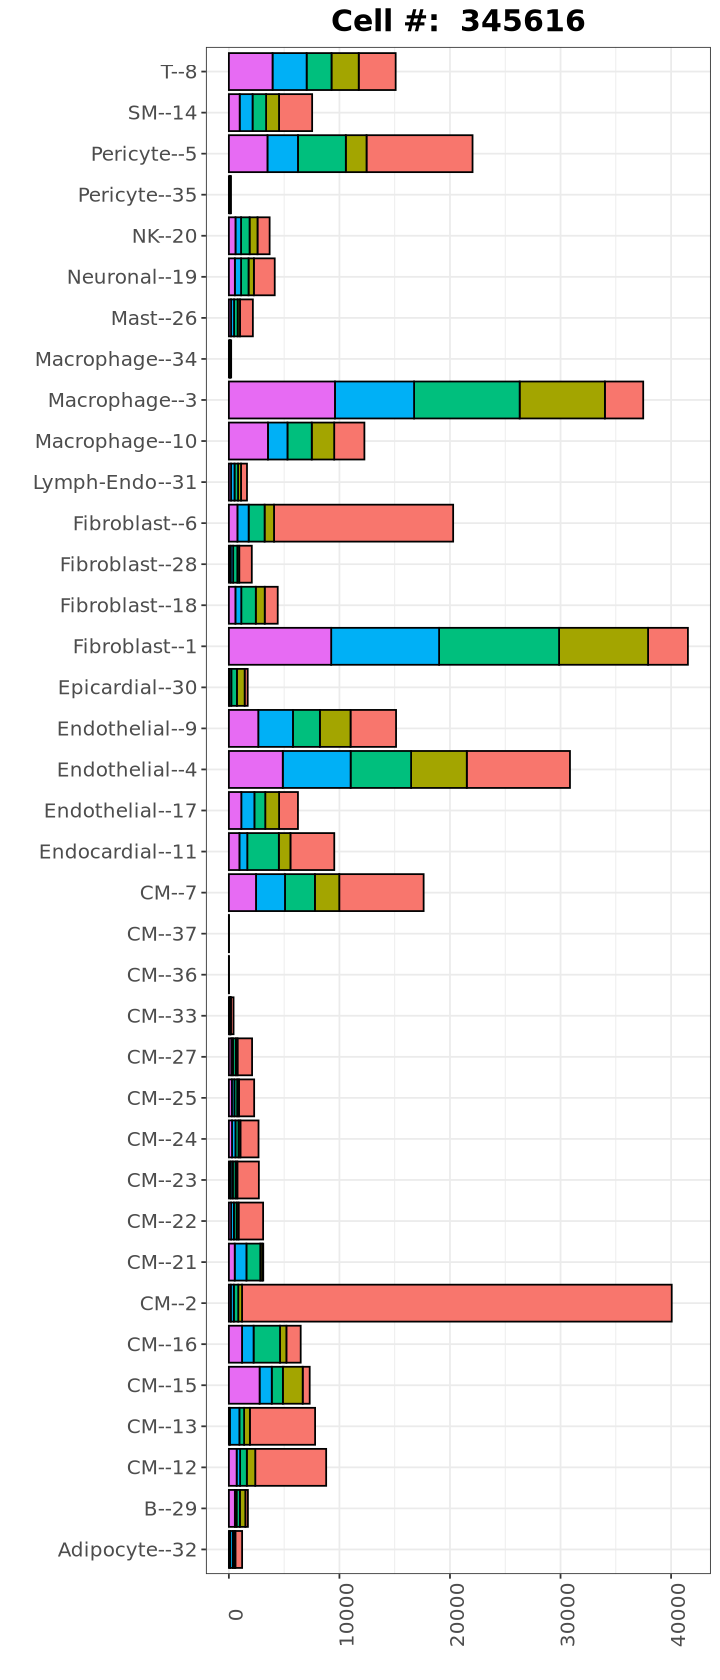

In [42]:
options(repr.plot.width=6, repr.plot.height=14)
gg1 & NoLegend()

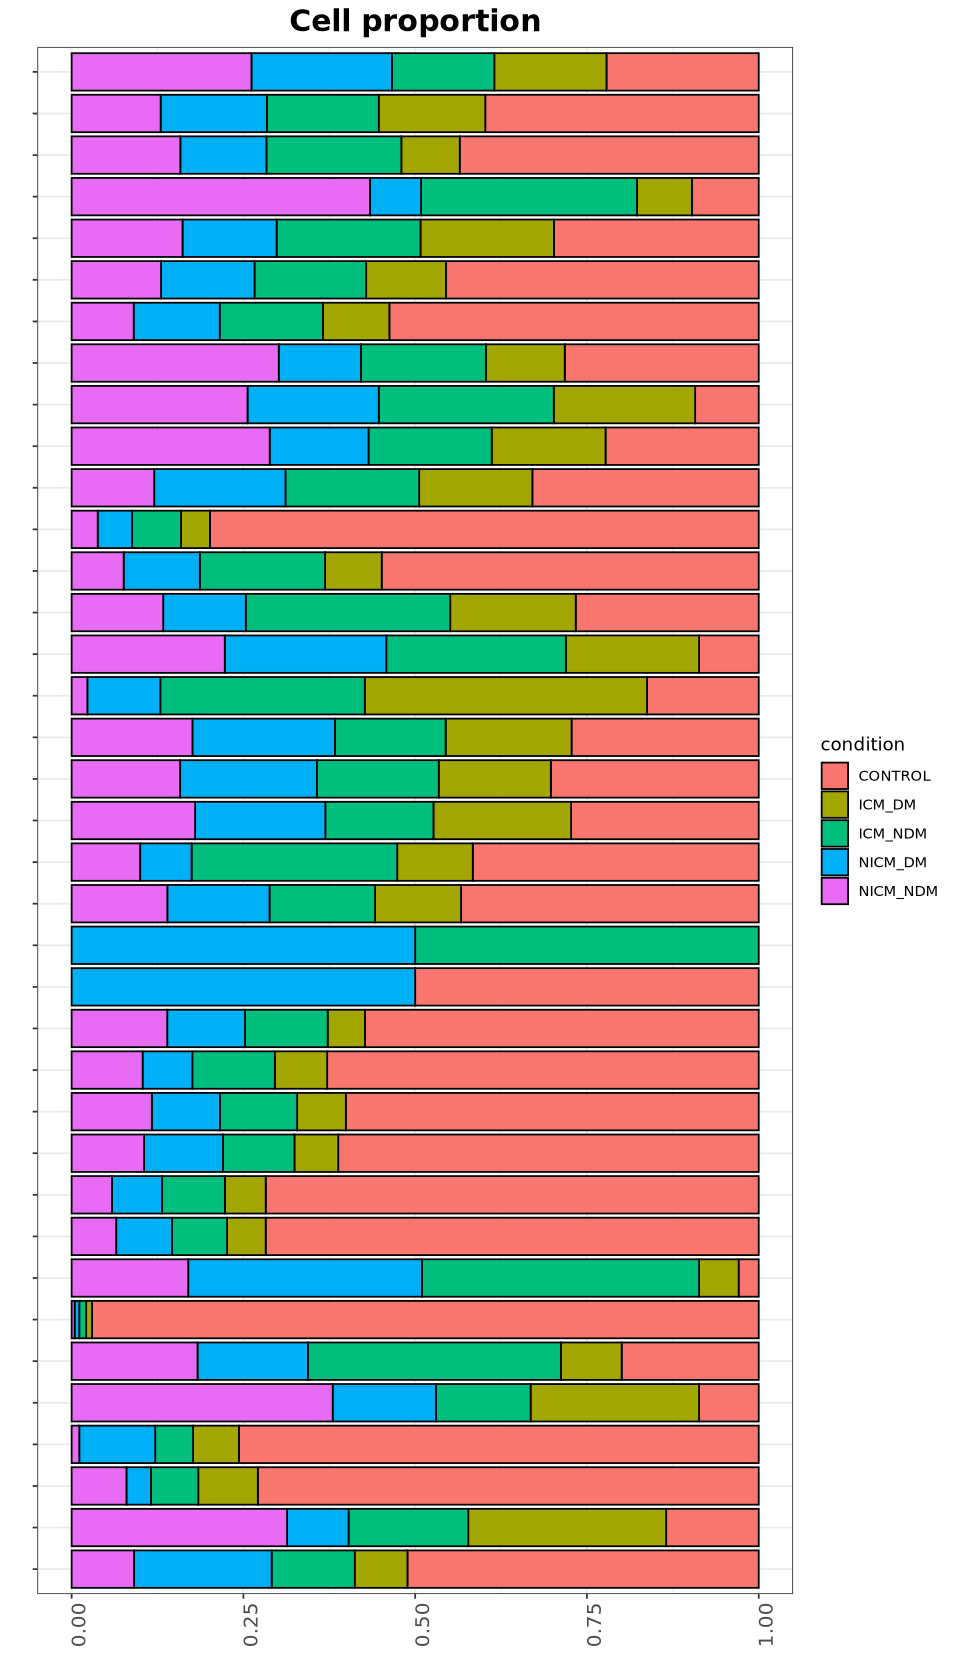

In [43]:
options(repr.plot.width=8, repr.plot.height=14)
gg2

In [44]:
### Write  RDS
log_print("Saving RDS")
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.rds", sep = "")
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"
[1] "RDS - Saved"
